# TEST different approach

In [2]:
from src.image_OCT import *
from src.image_Quantification import *
from src.image_Quantification_2 import *
from matplotlib import pyplot as plt
import numpy as np
from scipy import interpolate
import os
from os import listdir
from os.path import isfile, join
import re
import pandas as pd
import math 
import seaborn as sns
from sklearn import datasets, svm

dirname = os.getcwd()
print(dirname)
savefold=os.path.join(dirname, 'Data\Figure\\') # "C:/Users/csoub/OneDrive/Bureau/3A/Ensta/Super projet/Algo_Maelle/Data/Figure/"
extension=".png"
%matplotlib inline

def plot_treatment(im):
	plt.figure(figsize=(15,15))
	plt.subplot(221)
	plt.title("Input image")
	plt.imshow(im.OCT_brut,cmap="gray")
	plt.axis("off")
	plt.subplot(222)
	plt.title("Arrow removal")
	plt.imshow(im.OCT,cmap="gray")
	plt.axis("off")
	plt.subplot(223)
	plt.title("Exposure correction")
	plt.imshow(im.OCT_cut,cmap="gray")
	plt.axis("off")
	plt.subplot(224)
	plt.title("Flattening")
	plt.imshow(im.OCT_flat,cmap="gray")
	plt.axis("off")
	# plt.show()

c:\Users\csoub\OneDrive\Bureau\3A\Ensta\Super projet\Quantification_of_corneal_surgery_antecedent


Line


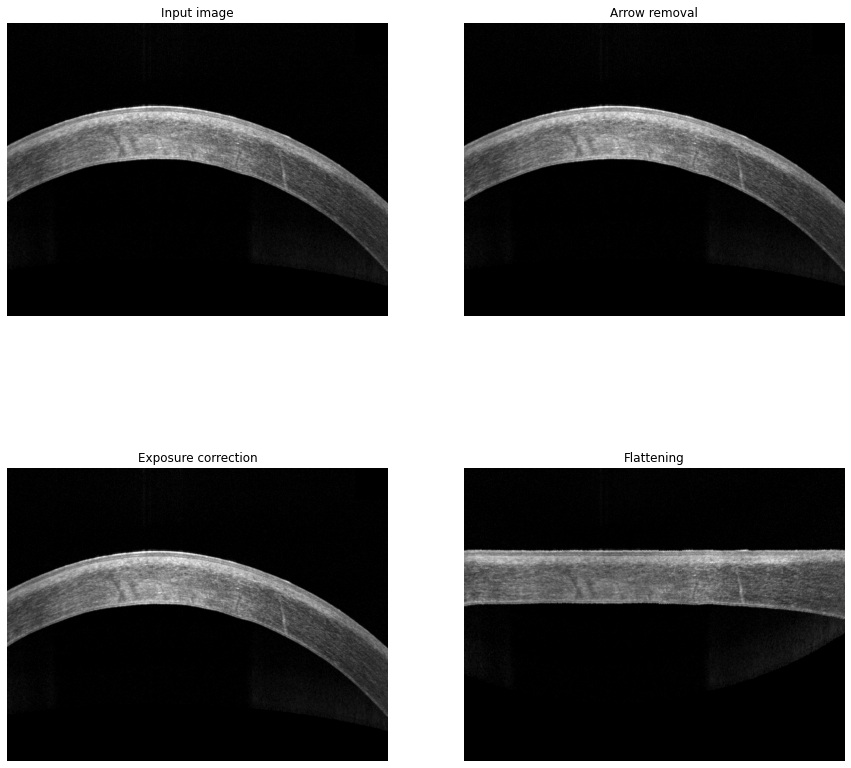

In [3]:
# filepathname=os.path.join(dirname, 'Data','HAZE','haze 3.jpg')
# filepathname=os.path.join(dirname, 'Data','Healthy','23923_BOULIS_OD.jpg')
# filepathname=os.path.join(dirname, 'Data','VILBERT_Maelle','test.jpg')
# filepathname=os.path.join(dirname, 'Data','Healthy_2','NASRAM_OD_Cross.jpg')
filepathname=os.path.join(dirname, 'Data','Fuchs_2','VANLUD_OD_6_Line.jpg')
# filepathname=os.path.join(dirname, 'Data','Healthy','80608_REZAZK_OS.jpg')

im=image_OCT(filepathname)
print(im.Path_eye)
im.AutoTreatment()
plot_treatment(im)
moving=False

(0.0, 102.0)

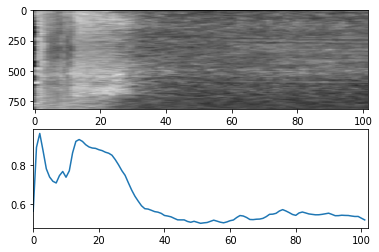

In [4]:
intentityProfile=np.mean(im.OCT_flat,1)							#Compute the profile

indexMax=np.argmax(intentityProfile)
peak=argrelextrema(intentityProfile, np.greater)
npeak1=np.unique(np.where(peak >= indexMax, peak,indexMax)[0])


pre_window=2
post_window=100
fig,ax=plt.subplots(2,1)
ax[0].imshow((im.OCT_flat[npeak1[0]-pre_window:npeak1[0]+post_window][:]).T,aspect="auto",cmap="gray")
ax[1].plot(intentityProfile[npeak1[0]-pre_window:npeak1[0]+post_window])
ax[1].set_xlim([0,pre_window+post_window])

In [5]:
filepathname_haze1=os.path.join(dirname, 'Data','HAZE','haze 1.jpg')
filepathname_haze2=os.path.join(dirname, 'Data','HAZE','haze 3.jpg')
filepathname_healthy1=os.path.join(dirname, 'Data','Healthy','23923_BOULIS_OD.jpg')
filepathname_healthy2=os.path.join(dirname, 'Data','VILBERT_Maelle','test.jpg')
filepathname_fuchs1=os.path.join(dirname, 'Data','Fuchs_2','VANLUD_OD_6_Line.jpg')
# filepathname_fuchs2=os.path.join(dirname, 'Data','Fuchs_2','FAIJEA_OS_1_Line.jpg')
filepathname_fuchs2=os.path.join(dirname, 'Data','Fuchs_2','SELNIC_OS_0_Line.jpg')

# filepathname=os.path.join(dirname, 'Data','Healthy','80608_REZAZK_OS.jpg')
test_ex=[filepathname_haze1,filepathname_haze2,filepathname_healthy1,filepathname_healthy2,filepathname_fuchs1,filepathname_fuchs2]
test_type=["haze1","haze2","healthy1","healthy2","fuchs1",'fuchs2']

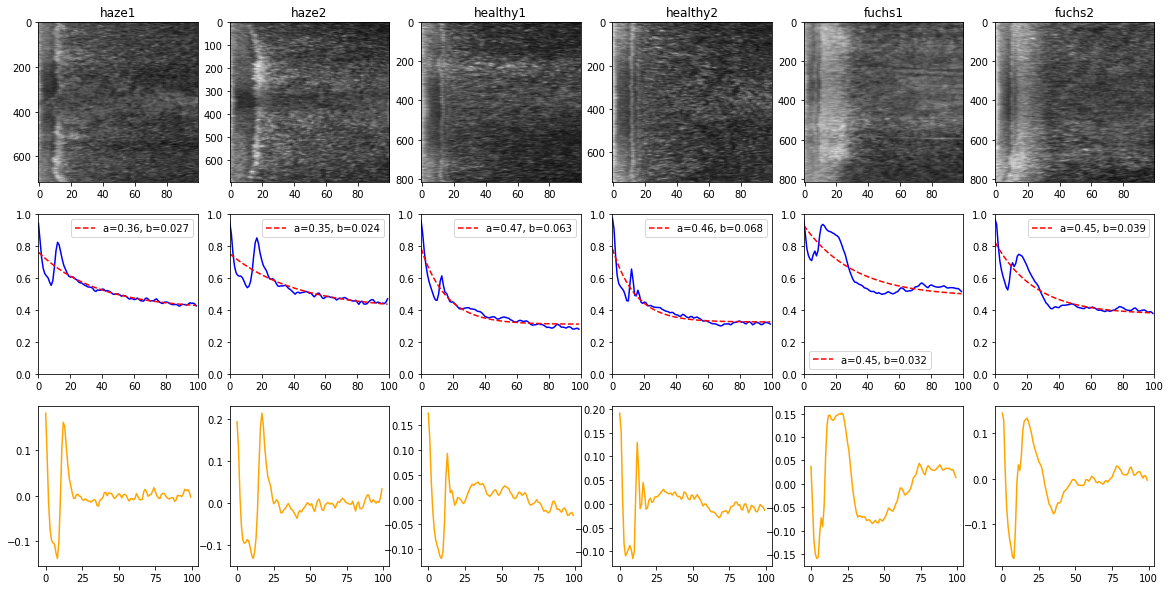

In [6]:
def func(x, a, b, c):
    return a * np.exp(-b * x) + c

n=len(test_ex)
fig,ax=plt.subplots(3,n,figsize=(20,10))
for i,filepathname in enumerate(test_ex):
    name=test_type[i]
    im=image_OCT(filepathname)
    im.AutoTreatment()
    intentityProfile=np.mean(im.OCT_flat,1)							#Compute the profile

    indexMax=np.argmax(intentityProfile)
    peak=argrelextrema(intentityProfile, np.greater)
    npeak1=np.unique(np.where(peak >= indexMax, peak,indexMax)[0])

    xdata=np.arange(0,post_window)
    ydata=intentityProfile[npeak1[0]:npeak1[0]+post_window]
    popt, pcov = curve_fit(func, xdata, ydata)
    ydata_fit=func(xdata, *popt)

    pre_window=0
    post_window=100
    ax[0][i].set_title(name)
    ax[0][i].imshow((im.OCT_flat[npeak1[0]-pre_window:npeak1[0]+post_window][:]).T,aspect="auto",cmap="gray")
    ax[1][i].plot(intentityProfile[npeak1[0]-pre_window:npeak1[0]+post_window],'b')
    ax[1][i].plot(ydata_fit,'r--',label="a={:.2}, b={:.2}".format(popt[0],popt[1]))
    ax[1][i].legend()
    ax[1][i].set_xlim([0,pre_window+post_window])
    ax[1][i].set_ylim([0,1])
    ax[2][i].plot(ydata-ydata_fit,'orange')

In [7]:
print(npeak1[0:3])

[187 198 202]


In [144]:
from scipy.signal import savgol_filter

def gaus(x,a,x0,sigma):
    	return a*np.exp(-(x-x0)**2/(2*sigma**2))

def exp_decr(x, a, b, c):
    return a * np.exp(-b * x) + c

class image_Quantification3(object):
	def __init__(self, image_OCT_element,movingWin=False):
		"""[Initialise the creation of the object image_Quantification by computiong the profile and calculate the quantifiers via Profile_quantification(_moving) and Quantification_parameters(_moving)]
		Args:
			image_OCT_element ([image_OCT]): [object of the class image_OCT]
			plot (bool, optional): [to rather plot fligure automatically or not]. Defaults to False.
			moving (bool, optional): [use the moving widow algorithm (True) or on the entire image (False)]. Defaults to False.

		Raises:
			ValueError: [Error during profile quantification or reation of the parameters]
		"""
		self.im=image_OCT_element
		self.image=self.im.OCT_flat
		try:
			window=100
			N=self.im.OCT_flat.shape[1]-window
			N_p=N
			if movingWin:
				PeakWidth=0;Sigma=0;DataCov=0;Mean=0;MSE=0;Area_ratio=0;Alpha=0;Beta=0;IntensityPeak=0
				for i in range(N):
					self.image=self.im.OCT_flat[:,i:(i+window)]
					# print(self.image)
					try:
						self.Profile_quantification()
						self.Quantification_parameters()
					except:
						N_p-=1
					PeakWidth+=self.PeakWidth
					Sigma+=self.Sigma
					DataCov+=self.DataCov
					Mean+=self.Mean
					MSE+=self.MSE
					Area_ratio+=self.Area_ratio
					Alpha+=self.Alpha
					Beta+=self.Beta
					IntensityPeak+=self.IntensityPeak
				self.PeakWidth=PeakWidth/N_p
				self.Sigma=Sigma/N_p
				self.DataCov=DataCov/N_p
				self.Mean=Mean/N_p
				self.MSE=MSE/N_p
				self.Area_ratio=Area_ratio/N_p
				self.Alpha=Alpha/N_p
				self.Beta=Beta/N_p
				self.IntensityPeak=IntensityPeak/N_p
				self.parameters={
					"PeakWidth": self.PeakWidth,
					"Sigma": self.Sigma,
					"DataCov": self.DataCov,
					"Mean": self.Mean,
					"MSE": self.MSE,
					"AreaRatio": self.Area_ratio,
					"Alpha": self.Alpha,
					"Beta": self.Beta,
					"IntensityPeak":self.IntensityPeak
				}
				print(str(N_p)+"/"+str(N)+" window computed")
			else:
				self.Profile_quantification()
				self.Quantification_parameters()
		except:
			message="\n"+"*"*50+"\n"+"Error in image_Quantification init: Image quantification impossible"
			raise ValueError(message)

	def getPeaks(self,intentityProfile,displayedPeak=3):
		"""[Return the #displayedPeak first peak position on the intencity profile in a 1D np-array]

		Args:
			intentityProfile ([1D np-array]): [Mean axial profile]
			displayedPeak (int, optional): [# of peaks to detect]. Defaults to 3.
		"""
		indexMax=np.argmax(intentityProfile)
		peak=argrelextrema(intentityProfile, np.greater)
		npeak1=np.unique(np.where(peak >= indexMax, peak,indexMax)[0])
		return(npeak1[0:displayedPeak])


	def getLowPeak(self,profile,peaks):
		"""[From the position of the second peak of the intensity profile, find the first local hollows in both direction arround the peak.
  			Hollows are detected by looking for local minimum, in case there is no local min:
     		- If it is a constant decrease, then lowpeak is define as the last ascan position available on the side studied
       		A filter is then applied:
         	The two lowpeaks are selected to have the same distance from the central peak as the minimal distance from the central peak to the two possition of lateral hollows]

		Args:
			peak ([1D np-array]): [first peaks position on the axial intencity profile]
			cropedProfile ([type]): [description]
			xmin ([type]): [description]
		"""
		peakLow=argrelextrema(profile, np.less)+self.xmin
		low1=np.unique(np.where(peakLow < peaks[1], peakLow,peaks[1])[0])#[:-1]
		if(low1.shape[0]>1):
				xlow1=low1[-1]
				if xlow1==peaks[1]:
					xlow1=low1[-2]
		else:
			xlow1=low1[0]
		
		low2=np.where(peakLow >= peaks[1], peakLow,peaks[1])[0]
		low2=low2[profile[low2-self.xmin]<0.8*profile[peaks[1]-self.xmin]]
		low2=np.unique(low2)
		if(low2.shape[0]>1):
			xlow2=low2[0]
			if xlow2==peaks[1]:
				xlow2=low2[1]
		elif (low2.shape[0]==1):
			xlow2=low2[0]
			if xlow2==peaks[1]:
				xlow2=profile.shape[0]+self.xmin-1
		else:
			xlow2=profile.shape[0]+self.xmin-1
		self.hollows=[xlow1,xlow2]

	def Profile_quantification(self,displayedPeak=3,pre_window=2,post_window=100):
		"""[summary]
		Args:
			displayedPeak (int, optional): [#of peak to compute]. Defaults to 2.
			window (int, optional): [number of ascan to consider left to first peak and right to second peak for ploting]. Defaults to 10.

		Raises:
			ValueError: [Error if the profile can be averaged]
		"""
		self.pre_window=pre_window
		self.post_window=post_window
		try:
			self.intentityProfile=np.mean(self.image,1)							#Compute the profile
		except:
			message="\n"+"*"*50+"\n"+"Error in image_Quantification Profile quantification: OCT_flat do not exist, run AutoTreatment or Flatenning before Profile_quantification"
			raise ValueError(message)

		peak=self.getPeaks(self.intentityProfile,displayedPeak)
		xdata=np.arange(0,post_window)
		ydata=self.intentityProfile[peak[0]:peak[0]+post_window]
		popt, pcov = curve_fit(exp_decr, xdata, ydata)
		ydata_fit=exp_decr(xdata, *popt)
		self.iProfileCrop=ydata
		self.iProfileExp=ydata_fit
		self.iProfileExpCorrection=self.iProfileCrop-self.iProfileExp
		self.xmin=peak[0]
		self.Alpha=popt[0]
		self.Beta=popt[1]
		self.peaks=peak

	def Quantification_parameters(self):
		intensity_peak_bowman=self.iProfileExpCorrection[self.peaks[1]-self.xmin]
		intensity_peak_under_bowman=self.iProfileExpCorrection[self.peaks[2]-self.xmin]
		self.underBowman=False
		if(intensity_peak_bowman<=intensity_peak_under_bowman/0.9):
			self.underBowman=True
			peaks=self.peaks[1:]
		else:
			peaks=self.peaks
		self.getLowPeak(self.iProfileExpCorrection,peaks)
		self.iProfileBell=self.iProfileExpCorrection[(self.hollows[0]-self.xmin):(self.hollows[1]+1-self.xmin)]
		self.Study_bell_curve()
		self.parameters={
			"PeakWidth": self.PeakWidth,
			"Sigma": self.Sigma,
			"DataCov": self.DataCov,
			"Mean": self.Mean,
			"MSE": self.MSE,
			"AreaRatio": self.Area_ratio,
			"Alpha": self.Alpha,
			"Beta": self.Beta,
			"IntensityPeak":self.IntensityPeak
		}
		return(0)

	def Study_bell_curve(self):
		PeakWidth=(self.hollows[1]-self.hollows[0])/self.im.pas
		ydata_init=self.iProfileBell-np.min(self.iProfileBell)
		n=ydata_init.shape[0]
		xdata_init=np.arange(0,n)
		mean=np.argmax(ydata_init)
		sigma=0.1
		tck = interpolate.splrep(xdata_init, ydata_init, s=0)
		xdata = np.arange(0, n-1, 1/5) 				#Multiply by 5 points number
		ydata = interpolate.splev(xdata, tck, der=0)
		popt,pcov = curve_fit(gaus,xdata,ydata,p0=[1,mean,sigma])
		## Std of the gaussian function
		sigma=popt[2]/self.im.pas
		## Mean position of gaussian function
		mean=popt[1]/self.im.pas
		ydata_fit=gaus(xdata_init,*popt)
		## Correlation between fitted data and initial data
		DataCov=np.cov(ydata_init,ydata_fit)
		DataCov=DataCov[0,1]
		## MSE between fitted data and initial data
		MSE=np.sqrt(np.sum((ydata_init-ydata_fit)**2))
  
		# Area calculation
		ydata=self.iProfileExpCorrection-np.min(self.iProfileExpCorrection)
		xdata=np.arange(0,len(ydata))
		x1=self.hollows[0];y1=ydata[self.hollows[0]-self.xmin]
		x2=self.hollows[1];y2=ydata[self.hollows[1]-self.xmin]
		m=(y1-y2)/(x1-x2);p=y1-m*x1
		x_lin_interp=np.arange(x1,x2,1)
		y_lin_interp=m*x_lin_interp+p
		ydata_c=np.concatenate((ydata[:(self.hollows[0]-self.xmin)],y_lin_interp,ydata[(self.hollows[1]-self.xmin):]))
		area_exp = np.trapz(ydata_c, dx=1)
		area_tot = np.trapz(ydata, dx=1)
		area_ratio = (area_tot-area_exp)/area_tot  
  
		self.iProfileBellGauss=ydata_fit
		self.MSE=MSE
		self.Sigma=sigma
		self.Mean=mean
		self.PeakWidth=PeakWidth
		self.DataCov=DataCov
		self.Area_ratio=area_ratio
		self.IntensityPeak=np.max(self.iProfileBellGauss)
  
	def Plot_ProfileExp(self):
		try:
			fig,ax=plt.subplots(1,3,figsize=(15,5))
			ax[0].imshow((self.image[self.peaks[0]-self.pre_window:self.peaks[0]+self.post_window][:]).T,aspect="auto",cmap="gray")
			ax[1].plot(self.iProfileCrop,'b')
			ax[1].plot(self.iProfileExp,'r--',label="a={:.2}, b={:.2}".format(self.Alpha,self.Beta))
			ax[1].plot(self.peaks-self.xmin,self.iProfileCrop[self.peaks-self.xmin],"bo",label="Peaks")
			ax[1].legend()
			ax[1].set_xlim([0,self.pre_window+self.post_window])
			ax[1].set_ylim([0,1])
			ax[2].plot(self.iProfileExpCorrection,'orange',label='Corrected profile')
			ax[2].plot(self.peaks-self.xmin,self.iProfileExpCorrection[self.peaks-self.xmin],color="orange",marker="o",linestyle='',label="Peaks")
			# ax[2].plot(savgol_filter(self.iProfileExpCorrection, 5, 2),'--')
			ax[2].legend()
			plt.show()
		except:
			message="\n"+"*"*50+"\n"+"Error in image_Quantification Profile quantification/Plot_ProfileExp: run Profile_quantification and Quantification_parameters before"
			raise ValueError(message)

	def Plot_ProfileQuantif(self):
		try:
			fig,ax=plt.subplots(1,2,figsize=(15,5))
			ax[0].plot(self.iProfileExpCorrection,'orange',label='Corrected profile')
			ax[0].plot(self.peaks-self.xmin,self.iProfileExpCorrection[self.peaks-self.xmin],color="orange",marker="o",linestyle='',label="Peaks")
			ax[0].plot(self.hollows-self.xmin,self.iProfileExpCorrection[self.hollows-self.xmin],color="green",marker="o",linestyle='',label="Hollows")
			ax[0].set_title("Fibrosis under bowman detected:"+str(self.underBowman))
			ax[0].legend()
			ax[1].plot(self.iProfileBell-np.min(self.iProfileBell),label="Extracted bell profile")
			ax[1].plot(self.iProfileBellGauss,'r--',label="N(mean={:.2},sigma={:.2})".format(self.Mean,self.Sigma))
			ax[1].legend()
			plt.show()
		except:
			message="\n"+"*"*50+"\n"+"Error in image_Quantification Profile quantification/Plot_ProfileQuantif: run Profile_quantification before"
			raise ValueError(message)

	def Plot_All(self):
		try:
			fig,ax=plt.subplots(3,2,figsize=(10,15))
			ax[0][0].imshow((self.image[self.peaks[0]-self.pre_window:self.peaks[0]+self.post_window][:]).T,aspect="auto",cmap="gray")
			ax[1][0].plot(self.iProfileCrop,'b')
			ax[1][0].plot(self.iProfileExp,'r--',label="a={:.2}, b={:.2}".format(self.Alpha,self.Beta))
			ax[1][0].plot(self.peaks-self.xmin,self.iProfileCrop[self.peaks-self.xmin],"bo",label="Peaks")
			ax[1][0].legend()
			ax[1][0].set_xlim([0,self.pre_window+self.post_window])
			ax[1][0].set_ylim([0,1])
			ax[2][0].plot(self.iProfileExpCorrection,'orange',label='Corrected profile')
			ax[2][0].plot(self.peaks-self.xmin,self.iProfileExpCorrection[self.peaks-self.xmin],color="orange",marker="o",linestyle='',label="Peaks")
			# ax[2].plot(savgol_filter(self.iProfileExpCorrection, 5, 2),'--')
			ax[2][0].legend()
   
			ax[0][1].plot(self.iProfileExpCorrection,'orange',label='Corrected profile')
			ax[0][1].plot(self.peaks-self.xmin,self.iProfileExpCorrection[self.peaks-self.xmin],color="orange",marker="o",linestyle='',label="Peaks")
			ax[0][1].plot(self.hollows-self.xmin,self.iProfileExpCorrection[self.hollows-self.xmin],color="green",marker="o",linestyle='',label="Hollows")
			ax[0][1].set_title("Fibrosis under bowman detected:"+str(self.underBowman))
			ax[0][1].legend()
			ax[1][1].plot(self.iProfileBell-np.min(self.iProfileBell),label="Extracted bell profile")
			ax[1][1].plot(self.iProfileBellGauss,'r--',label="N(mean={:.2},sigma={:.2})".format(self.Mean,self.Sigma))
			ax[1][1].legend()
			plt.show()
		except:
			message="\n"+"*"*50+"\n"+"Error in image_Quantification Profile quantification/Plot_ProfileQuantif: run Profile_quantification before"
			raise ValueError(message)

Line
711/718 window computed


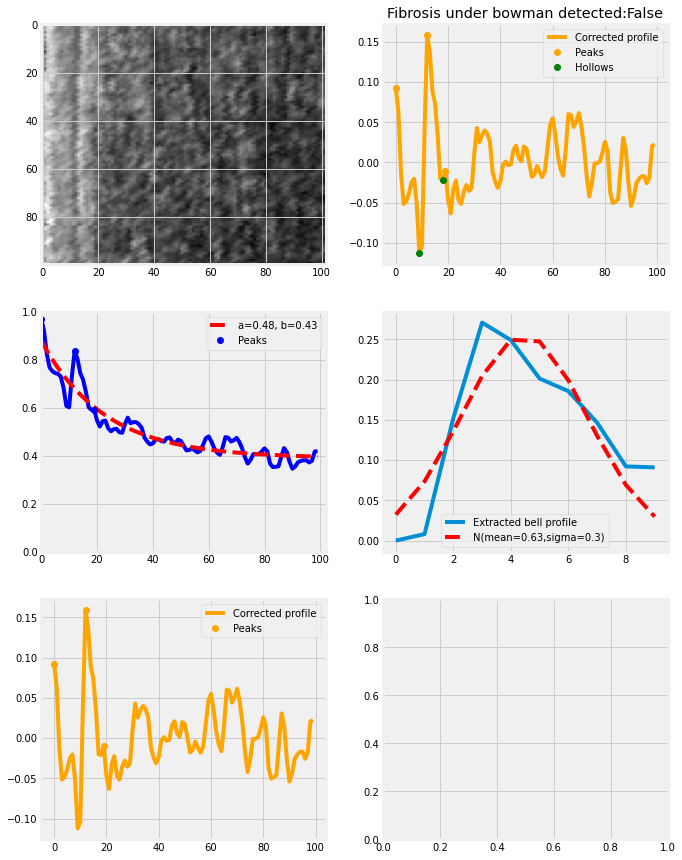

In [145]:
filepathname_haze1=os.path.join(dirname, 'Data','HAZE','haze 1.jpg')
filepathname_haze2=os.path.join(dirname, 'Data','HAZE','haze 3.jpg')
# filepathname_healthy1=os.path.join(dirname, 'Data','Healthy','23923_BOULIS_OD.jpg')
filepathname_healthy1=os.path.join(dirname, 'Data','Healthy','80608_REZAZK_OS.jpg')
filepathname_healthy2=os.path.join(dirname, 'Data','VILBERT_Maelle','test.jpg')
filepathname_fuchs1=os.path.join(dirname, 'Data','Fuchs_2','VANLUD_OD_6_Line.jpg')
# filepathname_fuchs2=os.path.join(dirname, 'Data','Fuchs_2','FAIJEA_OS_1_Line.jpg')
filepathname_fuchs2=os.path.join(dirname, 'Data','Fuchs_2','SELNIC_OS_0_Line.jpg')

im=image_OCT(filepathname_healthy1)
print(im.Path_eye)
im.AutoTreatment()
im_Q=image_Quantification3(im,movingWin=True)
# im_Q.Plot_ProfileExp()
# im_Q.Plot_ProfileQuantif()
im_Q.Plot_All()

In [146]:
def create_new_dataset(repository,healthy_value):
	files = [f for f in listdir(repository) if isfile(join(repository, f))]
	quantification=[]
	i=0
	i_list=[]
	for f in files:
		if(f[-3:]=="jpg"):
			i+=1
			try:
				im=image_OCT(os.path.join(repository, f))
			except:
				print("Error with: "+f+" image #"+str(i))
			try:
				im.AutoTreatment()
				im_Q=image_Quantification3(im,movingWin=True)
				# im_Q=image_Quantification_2(im,plot=False,intensity_corr=intensity_corr)
				parameters=im_Q.parameters
				parameters["Healthy"]=healthy_value
				parameters["Origin"]=f[:-4]
				quantification.append(parameters)
				# print(i,":",healthy)
				i_list.append(i)
			except:
				print("Error with: "+f+" image #"+str(i))
	n=len(quantification)
	print(n,"/",len(files)," files succesfully quantified")
	data=pd.DataFrame(quantification,index=range(n)) 
	return(data)

In [147]:
repertory_healthy=os.path.join(dirname, 'Data','Healthy')
healthy_value=1 #healthy
data_healthy=create_new_dataset(repertory_healthy,healthy_value)

repertory_haze=os.path.join(dirname, 'Data','HAZE')
healthy_value=0 #healthy
data_haze=create_new_dataset(repertory_haze,healthy_value)

717/718 window computed
671/671 window computed
718/718 window computed
718/718 window computed
717/718 window computed
716/718 window computed
715/718 window computed
711/718 window computed
717/718 window computed
714/718 window computed
714/718 window computed
717/718 window computed
12 / 12  files succesfully quantified
615/617 window computed
1168/1204 window computed
501/599 window computed
365/595 window computed
917/1172 window computed
944/1178 window computed
6 / 6  files succesfully quantified


In [148]:
data_learning=pd.concat([data_haze,data_healthy],ignore_index=True)
data_learning

,PeakWidth,Sigma,DataCov,Mean,MSE,AreaRatio,Alpha,Beta,IntensityPeak,Healthy,Origin
0,1.874065,0.508241,0.006765,1.078963,0.091430,0.057567,0.460297,0.279770,0.218738,0,haze 1
1,1.781266,0.505437,0.007537,1.054498,0.068323,0.053860,0.479155,0.207305,0.213036,0,haze 2
2,2.566296,0.668055,0.008368,1.328765,0.113908,0.090540,0.601094,0.270084,0.251215,0,haze 3
3,2.754901,0.763847,0.005392,1.361249,0.064652,0.035126,0.651020,0.450361,0.216297,0,haze 4
4,1.879002,0.471895,0.008951,0.933488,0.054336,0.056611,1.247226,0.240706,0.241080,0,haze 5
5,1.969133,0.529456,0.007837,1.093665,0.073602,0.043368,0.612332,0.358489,0.243823,0,haze 6
6,1.420129,0.339555,0.006593,0.908835,0.051339,0.037906,0.566977,0.157449,0.211986,1,23923_BOULIS_OD
7,1.152215,0.252956,0.007232,0.598820,0.053276,0.030626,0.498012,0.248681,0.212939,1,79296_BESNIC_OD
8,1.139792,0.271390,0.010969,0.661230,0.068347,0.029637,0.551087,0.245330,0.258105,1,80552_CORANT_OD
9,1.274150,0.294384,0.009691,0.767753,0.068058,0.052168,0.444521,0.297941,0.260280,1,80552_CORANT_OS


In [149]:
m_healthy=np.mean(data_healthy,0)
std_healthy=np.std(data_healthy,0)
m_haze=np.mean(data_haze,0)
std_haze=np.std(data_haze,0)
for i,type in enumerate(data_healthy.columns):
    if i<len(m_healthy):
    	print(type+":\n		m_healthy={:.2f}, m_haze={:.2f},s_healthy={:.2f},s_haze={:.2f}".format(m_healthy[i],m_haze[i],std_healthy[i],std_haze[i]))
    

PeakWidth:
		m_healthy=1.24, m_haze=2.14,s_healthy=0.09,s_haze=0.38
Sigma:
		m_healthy=0.28, m_haze=0.57,s_healthy=0.03,s_haze=0.11
DataCov:
		m_healthy=0.01, m_haze=0.01,s_healthy=0.00,s_haze=0.00
Mean:
		m_healthy=0.70, m_haze=1.14,s_healthy=0.08,s_haze=0.15
MSE:
		m_healthy=0.05, m_haze=0.08,s_healthy=0.01,s_haze=0.02
AreaRatio:
		m_healthy=0.04, m_haze=0.06,s_healthy=0.02,s_haze=0.02
Alpha:
		m_healthy=0.22, m_haze=0.68,s_healthy=0.81,s_haze=0.27
Beta:
		m_healthy=0.25, m_haze=0.30,s_healthy=0.08,s_haze=0.08
IntensityPeak:
		m_healthy=0.24, m_haze=0.23,s_healthy=0.05,s_haze=0.02
Healthy:
		m_healthy=1.00, m_haze=0.00,s_healthy=0.00,s_haze=0.00


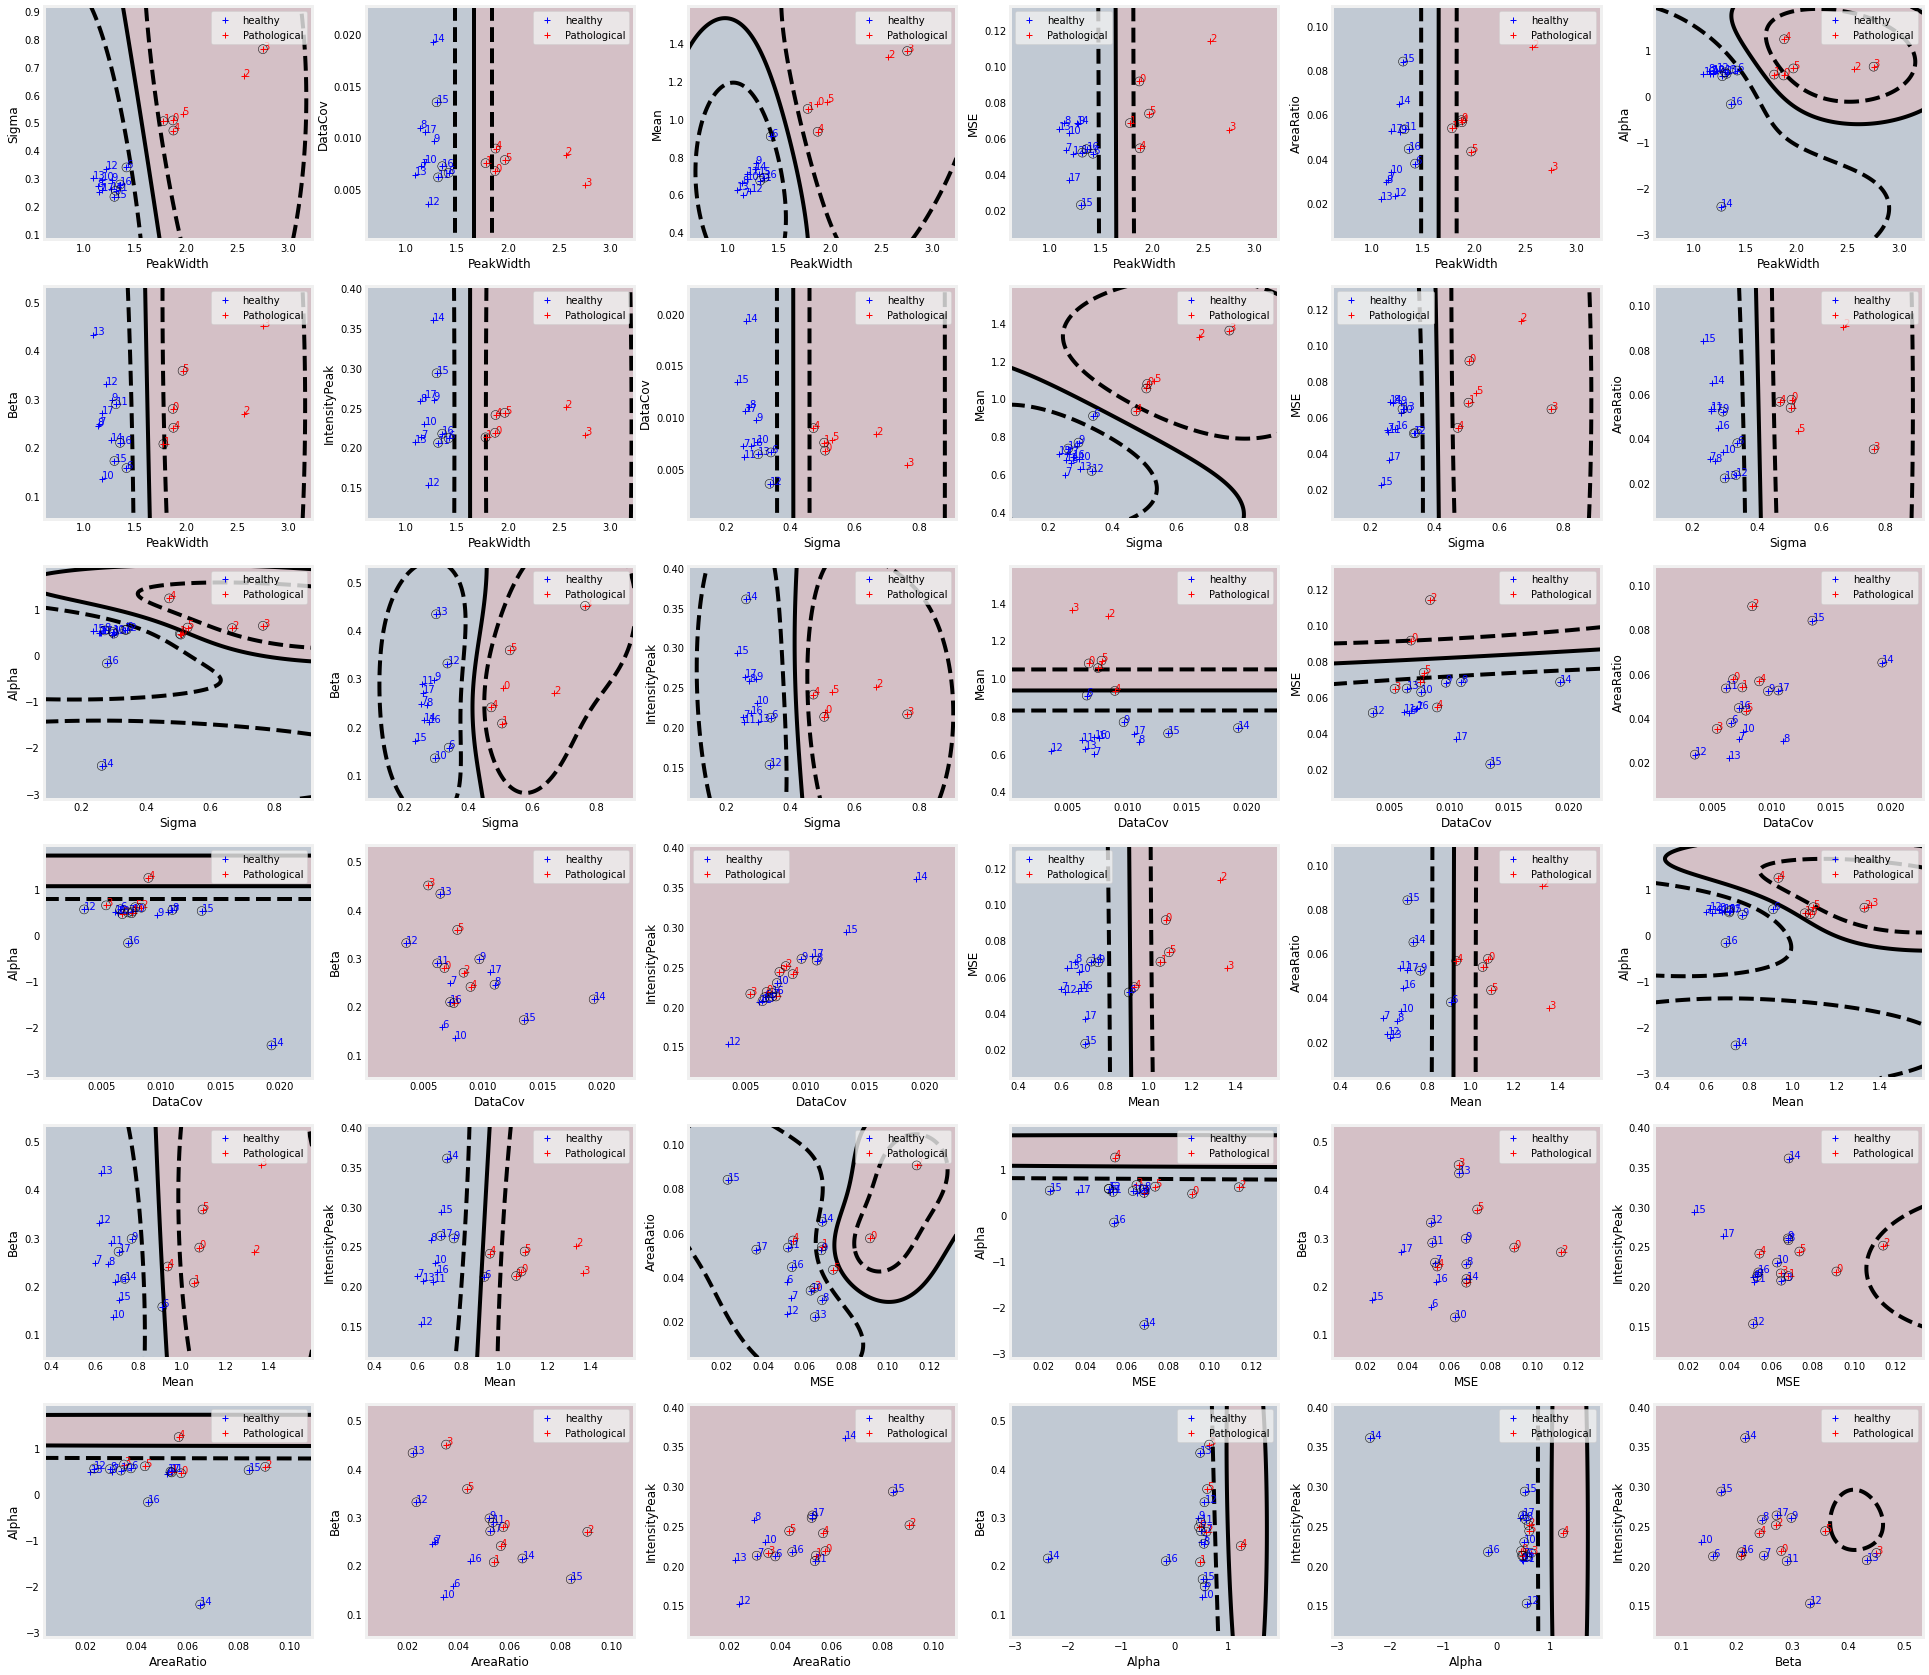

In [150]:
#Plot two by two
import warnings
warnings.filterwarnings("ignore")

data=data_learning
data_copy=data.drop(["Healthy","Origin"],axis=1)
data_copy=(data_copy-np.mean(data_copy,0))/np.std(data_copy,0)
cor=data_copy.corr()
# sns.heatmap(cor, square = True, cmap="coolwarm",linewidths=.5,annot=True )

variable=data_copy.columns
k=len(variable)
comb=math.comb(k,2)
	
plt.figure(figsize=(30,30))
nline=6
ncol=comb//nline+int(comb/nline-comb//nline+0.5)
l=0
for i in range(k-1):
    for j in range(i+1,k):
        l+=1
        plt.subplot(nline,ncol,l)
        x_class1=data[variable[i]][data["Healthy"]==1]
        y_class1=data[variable[j]][data["Healthy"]==1]
        x_class0=data[variable[i]][data["Healthy"]==0]
        y_class0=data[variable[j]][data["Healthy"]==0]
        plt.plot(x_class1.T,y_class1.T,"b+",label="healthy")
        plt.plot(x_class0.T,y_class0.T,"r+",label="Pathological")
        for m in range(len(data)):
            if data["Healthy"][m]==1:
                plt.text(data[variable[i]][m],data[variable[j]][m],str(m),color="blue")
            else:
                plt.text(data[variable[i]][m],data[variable[j]][m],str(m),color="red")
        X=data[variable[i]]
        Y=data[variable[j]]
        Z=np.array([X.to_numpy().T,Y.to_numpy().T]).T
        C=np.array([data["Healthy"].to_numpy()]).T
        clf = svm.SVC()
        clf.fit(Z, C)
        x_min = Z[:, 0].min()-1*np.std(Z[:, 0])
        x_max = Z[:, 0].max()+1*np.std(Z[:, 0])
        y_min = Z[:, 1].min()-1*np.std(Z[:, 1])
        y_max = Z[:, 1].max()+1*np.std(Z[:, 1])
        XX, YY = np.mgrid[x_min:x_max:200j, y_min:y_max:200j]
        Z = clf.decision_function(np.c_[XX.ravel(), YY.ravel()])
        Z = Z.reshape(XX.shape)
        plt.scatter(clf.support_vectors_[:, 0],clf.support_vectors_[:, 1],s=80,facecolors="none",zorder=10,edgecolors="k")
        plt.pcolormesh(XX, YY, Z > 0, cmap="RdBu",alpha=0.2) #plt.cm.Paired
        plt.contour(XX,YY,Z,colors=["k", "k", "k"],linestyles=["--", "-", "--"],levels=[-0.5, 0, 0.5],linewidth=0.1)
        plt.xlabel(variable[i])
        plt.ylabel(variable[j])
        plt.legend()
        

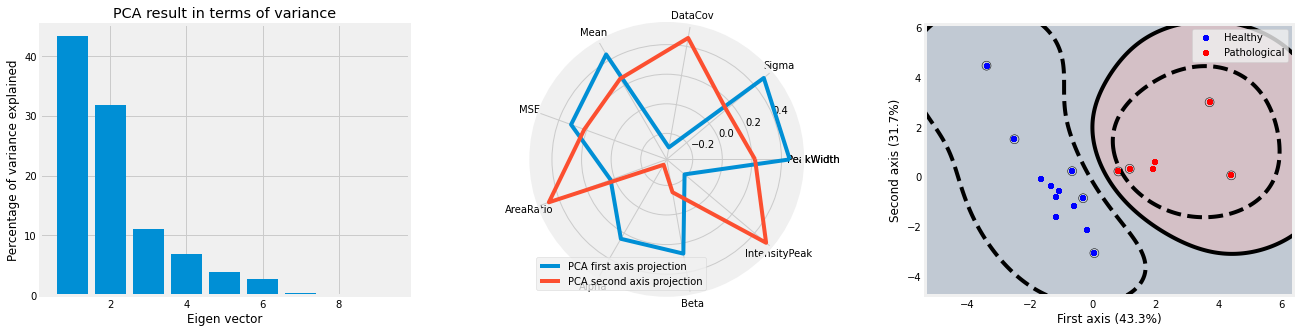

In [151]:
# PCA
import warnings
warnings.filterwarnings("ignore")
from sklearn.decomposition import PCA
from sklearn import svm

data_copy=data.drop(["Healthy","Origin"],axis=1)
data_copy=(data_copy-np.mean(data_copy,0))/np.std(data_copy,0)
N=len(data_copy)
K=len(data_copy.columns)
pca = PCA()
pca.fit(data_copy)


plt.figure(figsize=(20,5))
plt.subplot(131)
plt.bar(np.arange(1,K+1,1),pca.explained_variance_ratio_*100)
plt.xlabel('Eigen vector')
plt.ylabel('Percentage of variance explained')
plt.title("PCA result in terms of variance")
plt.subplot(132,polar=True)
categories = data_copy.columns
categories = [*categories, categories[0]]
axis1= pca.components_[0]
axis1 = [*axis1, axis1[0]]
axis2= pca.components_[1]
axis2 = [*axis2, axis2[0]]
label_loc = np.linspace(start=0, stop=2 * np.pi, num=len(axis1))
plt.plot(label_loc, axis1, label='PCA first axis projection')
plt.plot(label_loc, axis2, label='PCA second axis projection')
lines, labels = plt.thetagrids(np.degrees(label_loc), labels=categories)
plt.legend()

X=np.sum(data_copy*pca.components_[0],axis=1)
Y=np.sum(data_copy*pca.components_[1],axis=1)
Z=np.array([X.to_numpy().T,Y.to_numpy().T]).T
C=np.array([data["Healthy"].to_numpy()]).T
clf = svm.SVC()
clf.fit(Z, C)
x_min = Z[:, 0].min()-1*np.std(Z[:, 0])
x_max = Z[:, 0].max()+1*np.std(Z[:, 0])
y_min = Z[:, 1].min()-1*np.std(Z[:, 1])
y_max = Z[:, 1].max()+1*np.std(Z[:, 1])

XX, YY = np.mgrid[x_min:x_max:200j, y_min:y_max:200j]
Z = clf.decision_function(np.c_[XX.ravel(), YY.ravel()])
Z = Z.reshape(XX.shape)

plt.subplot(133)
plt.scatter(X[data["Healthy"]==1],Y[data["Healthy"]==1],c="b",marker="+",label="Healthy",zorder=10)
plt.scatter(X[data["Healthy"]==0],Y[data["Healthy"]==0],c="r",marker="+",label="Pathological",zorder=10)

plt.scatter(clf.support_vectors_[:, 0],clf.support_vectors_[:, 1],s=80,facecolors="none",zorder=10,edgecolors="k")
plt.pcolormesh(XX, YY, Z > 0, cmap="RdBu",alpha=0.2) #plt.cm.Paired
plt.contour(XX,YY,Z,colors=["k", "k", "k"],linestyles=["--", "-", "--"],levels=[-0.5, 0, 0.5],linewidth=1)
plt.xlabel("First axis ({:.1f}%)".format(pca.explained_variance_ratio_[0]*100))
plt.ylabel("Second axis ({:.1f}%)".format(pca.explained_variance_ratio_[1]*100))
plt.legend()

pca = PCA(n_components=2)
data_proj=pca.fit(data_copy,data["Healthy"])

In [152]:
#SVM LOO test

import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import confusion_matrix
X=np.sum(data_copy*pca.components_[0],axis=1)
Y=np.sum(data_copy*pca.components_[1],axis=1)
Z=np.array([X.to_numpy().T,Y.to_numpy().T]).T
C=np.array([data["Healthy"].to_numpy()]).T

loo = LeaveOneOut()
loo.get_n_splits(Z)
result=[]
result_pred=[]
conf=np.zeros((2,2))
for train_index, test_index in loo.split(X):
	print("TRAIN:", train_index, "TEST:", test_index)
	X_train, X_test = Z[train_index], Z[test_index]
	y_train, y_test = C[train_index], C[test_index]
	clf = svm.SVC()
	clf.fit(X_train, y_train)
	y_predict=clf.predict(X_test)
	result.append(y_test.ravel()[0])
	result_pred.append(y_predict.ravel()[0])
	if y_predict[0]==y_test[0][0] and y_test[0][0]==0:
		conf[0,0]+=1
	elif y_predict[0]!=y_test[0][0] and y_test[0][0]==1:
		print(y_predict,y_test)
		conf[0,1]+=1
	elif y_predict[0]!=y_test[0][0] and y_test[0][0]==0:
		conf[1,0]+=1
	elif y_predict[0]==y_test[0][0] and y_test[0][0]==1:
		conf[1,1]+=1
# print(result_pred)
# print(result)
# print(result_pred==result)
# ytrain=data["Healthy"].to_numpy()
print(conf)

TRAIN: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17] TEST: [0]
TRAIN: [ 0  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17] TEST: [1]
TRAIN: [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17] TEST: [2]
TRAIN: [ 0  1  2  4  5  6  7  8  9 10 11 12 13 14 15 16 17] TEST: [3]
TRAIN: [ 0  1  2  3  5  6  7  8  9 10 11 12 13 14 15 16 17] TEST: [4]
TRAIN: [ 0  1  2  3  4  6  7  8  9 10 11 12 13 14 15 16 17] TEST: [5]
TRAIN: [ 0  1  2  3  4  5  7  8  9 10 11 12 13 14 15 16 17] TEST: [6]
TRAIN: [ 0  1  2  3  4  5  6  8  9 10 11 12 13 14 15 16 17] TEST: [7]
TRAIN: [ 0  1  2  3  4  5  6  7  9 10 11 12 13 14 15 16 17] TEST: [8]
TRAIN: [ 0  1  2  3  4  5  6  7  8 10 11 12 13 14 15 16 17] TEST: [9]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 11 12 13 14 15 16 17] TEST: [10]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 12 13 14 15 16 17] TEST: [11]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 13 14 15 16 17] TEST: [12]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 14 15 16 17] TEST: [13]
TRAIN: [ 0  1  2

## Random forest

[[ 6  0]
 [ 0 12]]
[0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1]
[0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1]


Text(0.5, 0, 'Relative Importance')

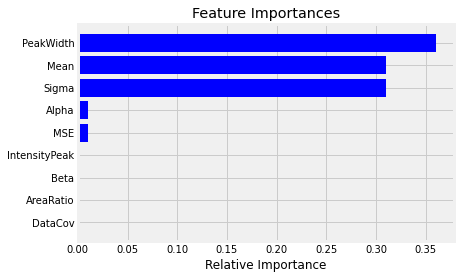

In [153]:
#RF LOO test
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators = 100, random_state = 2020)
data_copy=(data_copy-np.mean(data_copy,0))/np.std(data_copy,0)
rf.fit(data_copy, data["Healthy"])
predictions = rf.predict(data_copy)
# confusion_matrix(predictions, data["Healthy"])
predictions=(predictions+0.5).astype(int)
ytrain=data["Healthy"].to_numpy()

print(confusion_matrix(predictions,ytrain))
print(predictions)
print(ytrain)

importances = rf.feature_importances_
indices = np.argsort(importances)
# style du graphique 
plt.style.use('fivethirtyeight')
%matplotlib inline
plt.figure(1)
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [data_copy.columns[i] for i in indices])
plt.xlabel('Relative Importance')


In [154]:
repertory_healthy_2=os.path.join(dirname, 'Data','Healthy_2')
healthy_value=1 #healthy
data_healthy_2=create_new_dataset(repertory_healthy_2,healthy_value)
data_healthy_2

670/670 window computed
667/673 window computed
606/608 window computed
646/650 window computed
636/638 window computed
713/718 window computed
718/718 window computed
718/718 window computed
717/718 window computed
718/718 window computed
594/594 window computed
1159/1163 window computed
Error with: BOUJAD_OS_Cross.jpg image #13
1151/1156 window computed
692/692 window computed
656/661 window computed
717/718 window computed
682/683 window computed
716/718 window computed
716/718 window computed
665/666 window computed
651/651 window computed
717/718 window computed
1174/1191 window computed
684/686 window computed
1218/1222 window computed
589/589 window computed
1203/1205 window computed
592/592 window computed
1182/1187 window computed
686/687 window computed
663/663 window computed
717/718 window computed
718/718 window computed
611/614 window computed
1228/1234 window computed
587/588 window computed
1186/1234 window computed
638/638 window computed
1230/1234 window computed
636/

,PeakWidth,Sigma,DataCov,Mean,MSE,AreaRatio,Alpha,Beta,IntensityPeak,Healthy,Origin
0,0.924181,0.226839,0.011372,0.488096,0.057105,0.036896,0.408124,0.217273,0.252251,1,ARAILI_OS_Line
1,1.390604,0.486516,0.004219,0.805153,0.041231,0.028900,0.374378,0.313852,0.150726,1,ARAILI_OS_Pachy
2,1.106711,0.238147,0.010605,0.630256,0.045866,0.039300,0.468575,0.139962,0.250712,1,BEGABD_OD_Cross
3,1.049616,0.221560,0.010286,0.585892,0.049739,0.041205,0.449689,0.206445,0.256586,1,BEGABD_OD_Pachy
4,1.016043,0.230319,0.014111,0.563493,0.049185,0.044090,0.430221,0.230952,0.303533,1,BEGABD_OS_Cross
...,...,...,...,...,...,...,...,...,...,...,...
160,1.077434,0.265514,0.010453,0.655148,0.063912,0.034270,0.406047,0.268759,0.257123,1,TOUMAT_OS_Pachy
161,1.110542,0.248237,0.004750,0.614170,0.035898,0.030209,0.541853,0.264159,0.176444,1,WIETIP_OD_Line
162,1.073873,0.224370,0.004370,0.604910,0.018760,0.031579,0.498379,0.323801,0.162398,1,WIETIP_OD_Pachy
163,1.151042,0.218049,0.006450,0.643536,0.018181,0.042221,0.454220,0.209818,0.197371,1,WIETIP_OS_Line


(165, 9) 9
Ratio of true positive: 96.36%
Miss classified:6
Missclassify: LAMKEV_OS_Cross
Missclassify: MAGKOR_OS_Cross
Missclassify: MATCLA_OS_Line
Missclassify: MERLAM_OS_Cross
Missclassify: NASRAM_OD_Cross
Missclassify: NASRAM_OD_PachyWide


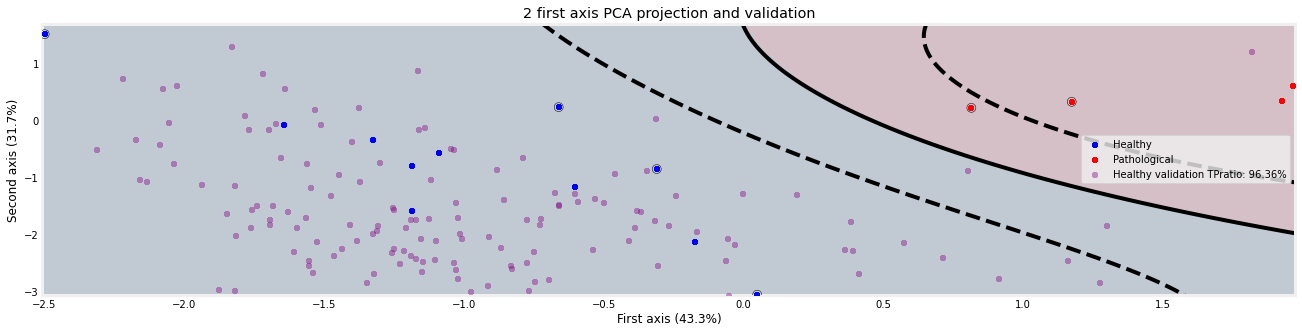

In [156]:
data_copy_2=data_healthy_2.drop(["Healthy","Origin"],axis=1)
print(data_copy_2.shape,len(pca.components_[0]))
data_copy_2=(data_copy_2-np.mean(data.drop(["Healthy","Origin"],axis=1),0))/np.std(data.drop(["Healthy","Origin"],axis=1),0)

X_2=np.sum(data_copy_2*pca.components_[0],axis=1)
Y_2=np.sum(data_copy_2*pca.components_[1],axis=1)
Z_2=np.array([X_2.to_numpy().T,Y_2.to_numpy().T]).T

class_z=np.ones((len(Z_2),1))
y_predict_2=clf.predict(Z_2)
print("Ratio of true positive: {:.2f}%".format(100*np.sum(y_predict_2)/len(y_predict_2)))
print("Miss classified:"+str(len(y_predict_2)-np.sum(y_predict_2)))
for i,y in enumerate(y_predict_2):
    if y==0:
        print("Missclassify:",data_healthy_2["Origin"][i])
        

X=np.sum(data_copy*pca.components_[0],axis=1)
Y=np.sum(data_copy*pca.components_[1],axis=1)
Z=np.array([X.to_numpy().T,Y.to_numpy().T]).T
C=np.array([data["Healthy"].to_numpy()]).T

x_min = np.min([ Z[:, 0].mean()-1*np.std(Z[:, 0]), Z_2[:, 0].mean()-1*np.std(Z_2[:, 0])])
x_max = np.max([ Z[:, 0].mean()+1*np.std(Z[:, 0]), Z_2[:, 0].mean()+1*np.std(Z_2[:, 0])])
y_min = np.min([ Z[:, 1].mean()-1*np.std(Z[:, 1]), Z_2[:, 1].mean()-1*np.std(Z_2[:, 1])])
y_max = np.max([ Z[:, 1].mean()+1*np.std(Z[:, 1]), Z_2[:, 1].mean()+1*np.std(Z_2[:, 1])])

XX, YY = np.mgrid[x_min:x_max:200j, y_min:y_max:200j]
Z = clf.decision_function(np.c_[XX.ravel(), YY.ravel()])
Z = Z.reshape(XX.shape)

plt.figure(figsize=(20,5))
plt.scatter(X[data["Healthy"]==1],Y[data["Healthy"]==1],c="b",marker="+",label="Healthy",zorder=10)
plt.scatter(X[data["Healthy"]==0],Y[data["Healthy"]==0],c="r",marker="+",label="Pathological",zorder=10)
plt.scatter(X_2,Y_2,c="purple",marker="+",label="Healthy validation TPratio: {:.2f}%".format(100*np.sum(y_predict_2)/len(y_predict_2)),zorder=10,alpha=0.4)

plt.scatter(clf.support_vectors_[:, 0],clf.support_vectors_[:, 1],s=80,facecolors="none",zorder=10,edgecolors="k")
plt.pcolormesh(XX, YY, Z > 0, cmap="RdBu",alpha=0.2) #plt.cm.Paired
plt.contour(XX,YY,Z,colors=["k", "k", "k"],linestyles=["--", "-", "--"],levels=[-0.5, 0, 0.5],linewidth=1)

plt.title("2 first axis PCA projection and validation")
plt.xlabel("First axis ({:.1f}%)".format(pca.explained_variance_ratio_[0]*100))
plt.ylabel("Second axis ({:.1f}%)".format(pca.explained_variance_ratio_[1]*100))

plt.xlim([x_min,x_max])
plt.ylim([y_min,y_max])
plt.legend()

LAMKEV_OS_Cross
Cross


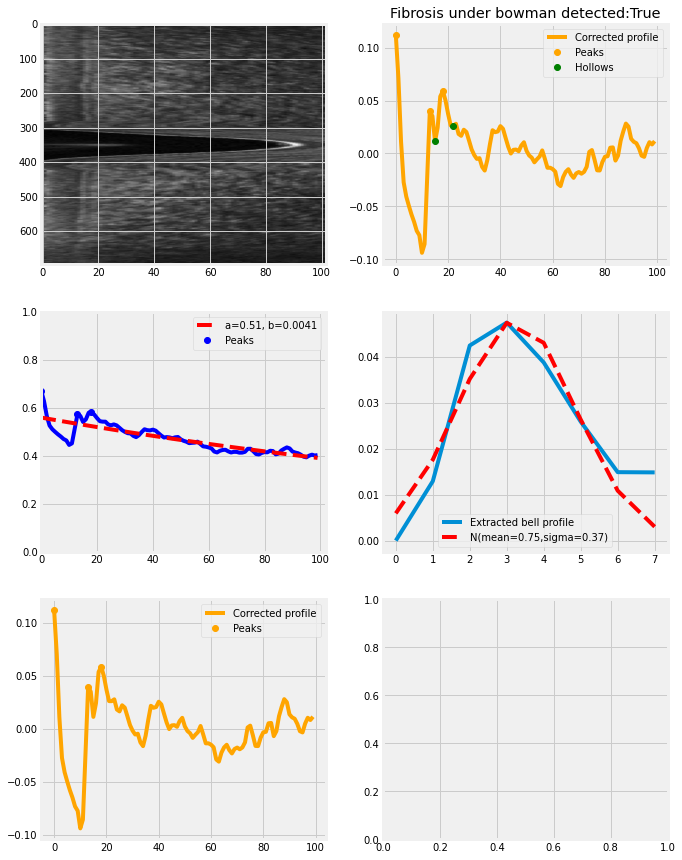

MAGKOR_OS_Cross
Cross


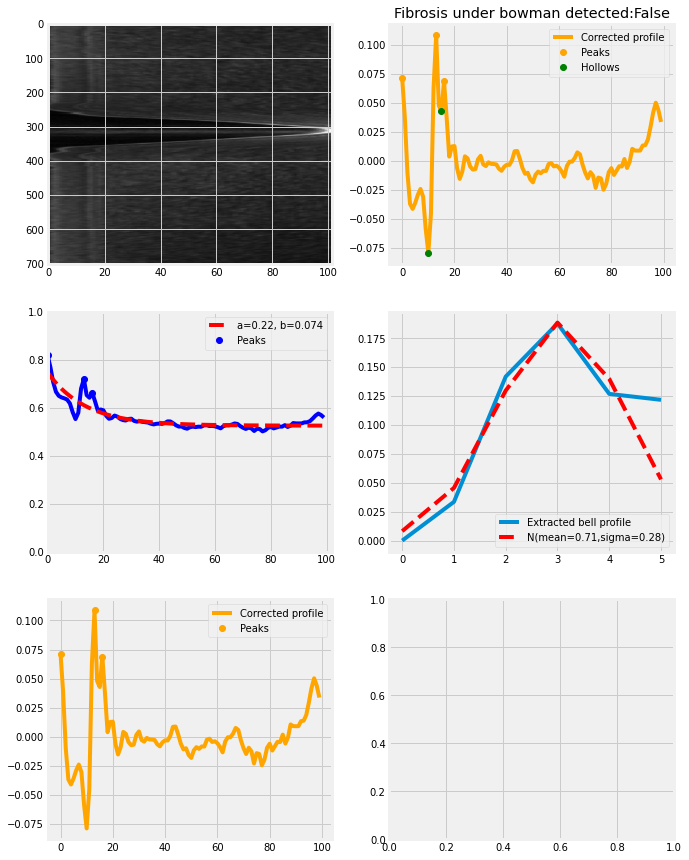

MATCLA_OS_Line
Line


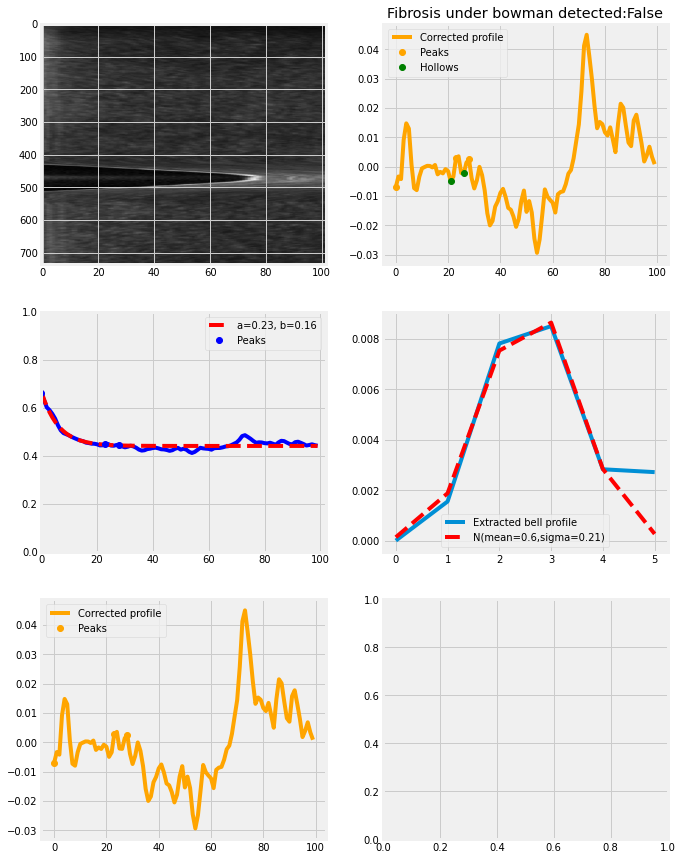

MERLAM_OS_Cross
Cross


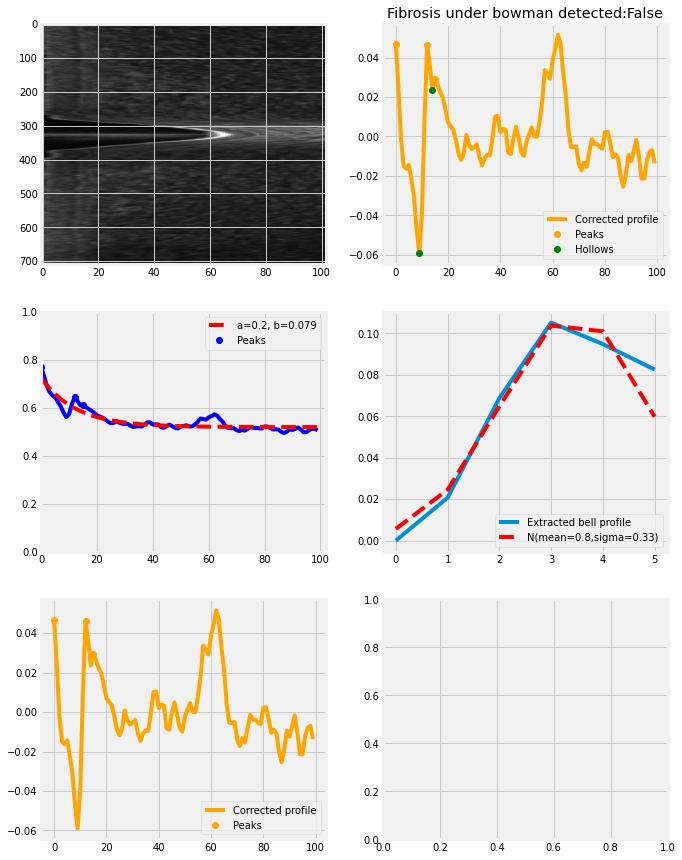

NASRAM_OD_Cross
Cross


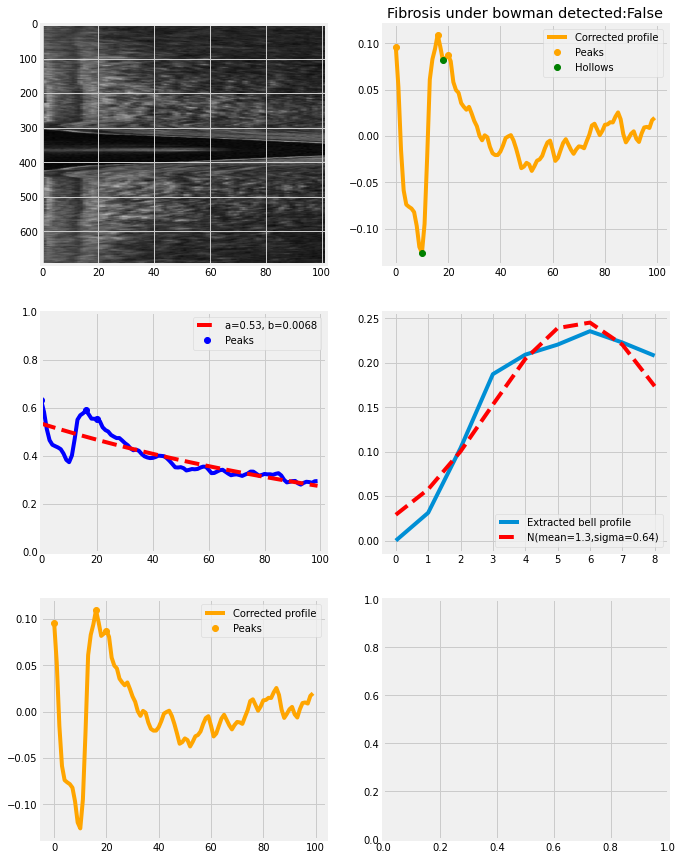

NASRAM_OD_PachyWide
PachyWide


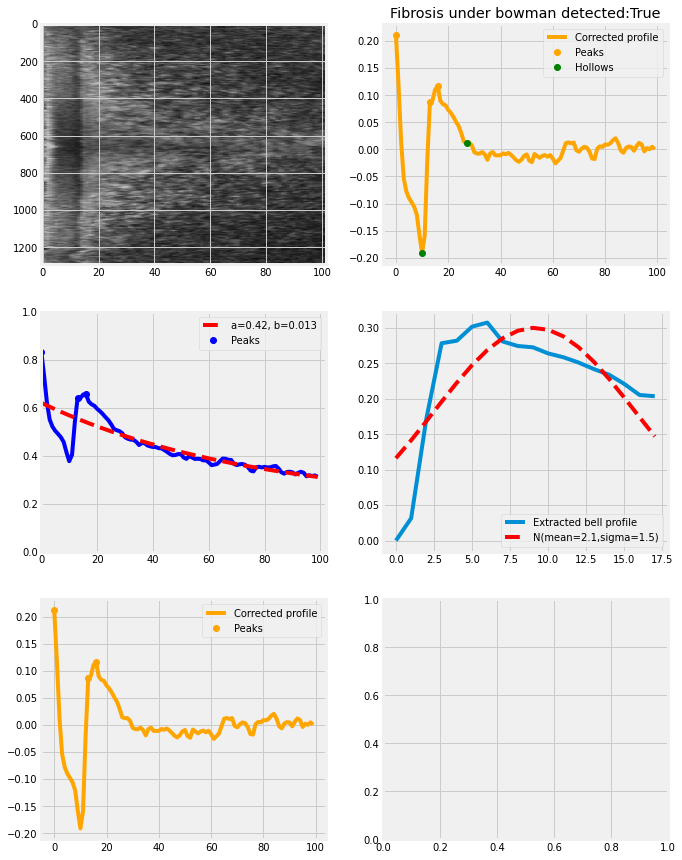

In [160]:
for i in range(len(y_predict_2)):
    if y_predict_2[i]==0:
        name=data_healthy_2["Origin"][i]
        print(name)
        filepathname=os.path.join(dirname, 'Data','Healthy_2',name+'.jpg')
        im=image_OCT(filepathname)
        print(im.Path_eye)
        im.AutoTreatment()
        im_Q=image_Quantification3(im,movingWin=False)
        im_Q.Plot_All()
        
        

In [161]:
repertory_fuchs=os.path.join(dirname, 'Data','Fuchs_2')
# repertory_fuchs=os.path.join(dirname, 'Data','Fuchs_renammed')
healthy_value=2 #fushs
data_fuchs=create_new_dataset(repertory_fuchs,healthy_value)

718/718 window computed
682/718 window computed
678/679 window computed
675/675 window computed
664/664 window computed
649/649 window computed
717/718 window computed
1160/1169 window computed
682/688 window computed
716/718 window computed
716/718 window computed
660/660 window computed
646/647 window computed
678/678 window computed
665/666 window computed
718/718 window computed
644/664 window computed
718/718 window computed
708/718 window computed
624/638 window computed
718/718 window computed
657/665 window computed
579/579 window computed
700/718 window computed
718/718 window computed
716/718 window computed
712/718 window computed
700/718 window computed
1123/1154 window computed
664/673 window computed
638/638 window computed
718/718 window computed
670/670 window computed
677/677 window computed
718/718 window computed
717/718 window computed
617/686 window computed
593/674 window computed
718/718 window computed
700/718 window computed
714/718 window computed
704/718 wind

In [162]:
# data_fuchs.to_pickle("./Dataset/data_set_fuchs_new_app_movingWin.pkl")
# data_learning.to_pickle("./Dataset/data_set_learning_new_app_movingWin.pkl")
# data_healthy_2.to_pickle("./Dataset/data_set_healthy_2_new_app_movingWin.pkl")